# CNGF5020 Project I：基于MODIS的中国县域火点时空分析（2010–2019）

本项目核心目标：
- 数据：整合 2010–2019 年 MODIS 火点监测数据与中国县级边界（`raw_data/CHN_County/CHN_County.shp`）。
- 任务：
  1) 构建火点地理数据集（经纬度→点矢量，WGS84）；
  2) 与县级边界进行空间叠加；
  3) 统计县域-年度/县域-年月火点数量与 FRP 指标；
  4) 进行全国年度趋势、季节性与“高火点县”对比；
  5) 产出分析图表与结果表格（CSV/GeoJSON），确保可复现。


# CNGF5020 Mini Group Project I: 农业秸秆焚烧识别  
##### 团队: Kaibiao Zhu朱楷彪    Junye Zhong钟俊烨   Hongyue Wu吴泓樾    Yueting Zhang张粤葶  
##### 目标: 利用 MODIS 火点 + 作物成熟期栅格数据，识别黑龙江省玉米/小麦收获后焚烧事件

**Step 1: 环境设置与路径定义**

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from pathlib import Path
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def show_versions():
    print(
        "Python:", sys.version.split(" ")[0],
        "| pandas:", pd.__version__,
        "| geopandas:", gpd.__version__,
        "| shapely:", Point.__module__.split(".")[0],
        "| rasterio:", rasterio.__version__
    )

show_versions()


Python: 3.11.14 | pandas: 2.3.3 | geopandas: 1.1.1 | shapely: shapely | rasterio: 1.4.3


In [2]:
# 路径与输出目录
from pathlib import Path

def find_repo_root(start=Path.cwd(), markers=('raw_data','requirements.txt','.git')):
    p = start.resolve()
    while True:
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            return start.resolve()
        p = p.parent

# 确保 BASE_DIR 指向项目根（适配 notebook 在 script 目录中运行的情况）
BASE_DIR = str(find_repo_root())
FIRE_DIR = os.path.join(BASE_DIR, 'raw_data', 'satellite_fire_data')
COUNTY_SHP = os.path.join(BASE_DIR, 'raw_data', 'CHN_County', 'CHN_County.shp')
CROPLAND_DIR = os.path.join(BASE_DIR, 'raw_data', 'cropland_distribution_and_phenological_data')

OUT_DIR = os.path.join(BASE_DIR, 'outputs')
os.makedirs(OUT_DIR, exist_ok=True)

print('BASE_DIR:', BASE_DIR)
print('FIRE_DIR exists:', os.path.isdir(FIRE_DIR))
print('COUNTY_SHP exists:', os.path.isfile(COUNTY_SHP))
print('OUT_DIR:', OUT_DIR)

print('✅ 路径设置完成')

BASE_DIR: F:\github desktop\course5020-project
FIRE_DIR exists: True
COUNTY_SHP exists: True
OUT_DIR: F:\github desktop\course5020-project\outputs
✅ 路径设置完成


**Step2: 加载并合并 MODIS 火点数据 (2010–2019)**

In [3]:
# 读取并合并 2010-2019 年 MODIS 火点数据（兼容不同列名组合）
csv_files = sorted(glob(os.path.join(FIRE_DIR, 'modis_20*_China.csv')))
assert len(csv_files) > 0, '未找到火点CSV文件，请检查路径和文件名模式。'
print("=== 详细文件诊断 ===")
print(f"FIRE_DIR: {FIRE_DIR}")
print(f"FIRE_DIR 绝对路径: {os.path.abspath(FIRE_DIR)}")
print(f"FIRE_DIR 是否存在: {os.path.exists(FIRE_DIR)}")

if os.path.exists(FIRE_DIR):
    # 列出所有文件和目录
    print(f"\n=== FIRE_DIR 目录内容 ===")
    all_items = os.listdir(FIRE_DIR)
    print(f"总项目数: {len(all_items)}")
    
    csv_files = []
    other_files = []
    subdirs = []
    
    for item in all_items:
        item_path = os.path.join(FIRE_DIR, item)
        if os.path.isdir(item_path):
            subdirs.append(item)
        elif item.lower().endswith('.csv'):
            csv_files.append(item)
        else:
            other_files.append(item)
    
    print(f"CSV 文件 ({len(csv_files)} 个):")
    for csv in sorted(csv_files):
        print(f"  📄 {csv}")
    
    print(f"\n子目录 ({len(subdirs)} 个):")
    for subdir in sorted(subdirs):
        print(f"  📁 {subdir}")
        
    print(f"\n其他文件 ({len(other_files)} 个):")
    for other in sorted(other_files):
        print(f"  📝 {other}")
    
    # 测试 glob 模式匹配
    print(f"\n=== Glob 模式匹配测试 ===")
    patterns_to_test = [
        'modis_20*_china.csv',
        'modis_20*.csv', 
        '*.csv'
    ]
    
    for pattern in patterns_to_test:
        matched_files = glob(os.path.join(FIRE_DIR, pattern))
        print(f"模式 '{pattern}': 匹配到 {len(matched_files)} 个文件")
        for f in matched_files:
            print(f"  ✅ {os.path.basename(f)}")

# 检查当前工作目录
print(f"\n=== 当前工作目录 ===")
print(f"当前目录: {os.getcwd()}")
print(f"BASE_DIR: {BASE_DIR}")
print(f"两者是否相同: {os.getcwd() == BASE_DIR}")

# 然后继续原来的代码，但使用小写模式
csv_files = sorted(glob(os.path.join(FIRE_DIR, 'modis_20*_china.csv')))
print(f"\n最终匹配到的文件数量: {len(csv_files)}")

if len(csv_files) == 0:
    print("❌ 错误：未找到匹配的火点CSV文件")
    # 这里可以选择退出或者抛出异常
    raise FileNotFoundError("未找到火点CSV文件，请检查文件名和路径")
else:
    print(f'✅ 发现 {len(csv_files)} 个CSV文件：', [os.path.basename(f) for f in csv_files])
print(f'发现 {len(csv_files)} 个CSV文件：', os.path.basename(csv_files[0]), '...')

# 期望列（若不存在则自动跳过）
desired_cols = [
    'latitude','longitude','brightness','scan','track','acq_date','acq_time',
    'satellite','instrument','confidence','version','bright_t31','frp','daynight','type'
]

# 指定列类型（仅对存在的列生效），减少内存占用
DTYPES = {
    'latitude': 'float32', 'longitude': 'float32',
    'brightness': 'float32', 'scan': 'float32', 'track': 'float32',
    'acq_time': 'int32', 'confidence': 'float32', 'version': 'string',
    'bright_t31': 'float32', 'frp': 'float32', 'daynight': 'string', 'type': 'float32'
}

# 探测首个文件中可用列
first_cols = pd.read_csv(csv_files[0], nrows=0).columns.str.lower().tolist()
# 有些数据列名可能为大写，将所有列名统一为小写后进行匹配
def read_with_lower_cols(path, **kwargs):
    df0 = pd.read_csv(path, **kwargs)
    df0.columns = df0.columns.str.lower()
    return df0

available = [c for c in desired_cols if c in first_cols]
parse_dates = ['acq_date'] if 'acq_date' in available else []
use_dtypes = {k: v for k, v in DTYPES.items() if k in available}

frames = []
for f in csv_files:
    df = read_with_lower_cols(
        f,
        dtype=use_dtypes if len(use_dtypes)>0 else None,
        usecols=available if len(available)>0 else None,
        parse_dates=parse_dates if len(parse_dates)>0 else None
    )
    frames.append(df)

fires = pd.concat(frames, ignore_index=True)
# 基础清洗
# 统一关键列存在性
for col in ['latitude','longitude']:
    assert col in fires.columns, f'关键列缺失: {col}'

if 'acq_date' in fires.columns and not np.issubdtype(fires['acq_date'].dtype, np.datetime64):
    # 若未解析为日期
    fires['acq_date'] = pd.to_datetime(fires['acq_date'], errors='coerce')

fires = fires.dropna(subset=['latitude','longitude','acq_date'])
fires['year'] = fires['acq_date'].dt.year.astype('int16')
fires['month'] = fires['acq_date'].dt.month.astype('int8')

print('合并后记录数:', len(fires))
fires.head()

=== 详细文件诊断 ===
FIRE_DIR: F:\github desktop\course5020-project\raw_data\satellite_fire_data
FIRE_DIR 绝对路径: F:\github desktop\course5020-project\raw_data\satellite_fire_data
FIRE_DIR 是否存在: True

=== FIRE_DIR 目录内容 ===
总项目数: 10
CSV 文件 (10 个):
  📄 modis_2010_china.csv
  📄 modis_2011_china.csv
  📄 modis_2012_china.csv
  📄 modis_2013_china.csv
  📄 modis_2014_china.csv
  📄 modis_2015_china.csv
  📄 modis_2016_china.csv
  📄 modis_2017_china.csv
  📄 modis_2018_china.csv
  📄 modis_2019_china.csv

子目录 (0 个):

其他文件 (0 个):

=== Glob 模式匹配测试 ===
模式 'modis_20*_china.csv': 匹配到 10 个文件
  ✅ modis_2010_china.csv
  ✅ modis_2011_china.csv
  ✅ modis_2012_china.csv
  ✅ modis_2013_china.csv
  ✅ modis_2014_china.csv
  ✅ modis_2015_china.csv
  ✅ modis_2016_china.csv
  ✅ modis_2017_china.csv
  ✅ modis_2018_china.csv
  ✅ modis_2019_china.csv
模式 'modis_20*.csv': 匹配到 10 个文件
  ✅ modis_2010_china.csv
  ✅ modis_2011_china.csv
  ✅ modis_2012_china.csv
  ✅ modis_2013_china.csv
  ✅ modis_2014_china.csv
  ✅ modis_2015_china.c

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,month
0,30.875900,120.131401,301.000000,1.1,1.0,2010-01-01,242,Terra,MODIS,44.0,6.2,278.500000,7.5,D,0.0,2010,1
1,28.608700,121.431602,309.399994,1.0,1.0,2010-01-01,243,Terra,MODIS,69.0,6.2,281.299988,10.1,D,0.0,2010,1
2,27.016300,102.224701,301.899994,1.9,1.3,2010-01-01,422,Terra,MODIS,49.0,6.2,284.799988,14.5,D,0.0,2010,1
3,26.571899,101.669899,300.700012,1.8,1.3,2010-01-01,422,Terra,MODIS,38.0,6.2,288.500000,7.1,D,2.0,2010,1
4,27.855200,100.614899,300.000000,1.4,1.2,2010-01-01,422,Terra,MODIS,12.0,6.2,278.899994,10.5,D,0.0,2010,1


In [4]:
# 置信度阈值与地理点构建
CONF_THRESHOLD = 30  # 可调整：仅保留置信度>=30的火点
fires_filt = fires.loc[fires['confidence'] >= CONF_THRESHOLD].copy()

# 构建 GeoDataFrame（WGS84）
geometry = [Point(xy) for xy in zip(fires_filt['longitude'], fires_filt['latitude'])]
fires_gdf = gpd.GeoDataFrame(fires_filt, geometry=geometry, crs='EPSG:4326')

print('过滤后记录数:', len(fires_gdf))
fires_gdf.head()


过滤后记录数: 994029


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,month,geometry
0,30.875900,120.131401,301.000000,1.1,1.0,2010-01-01,242,Terra,MODIS,44.0,6.2,278.500000,7.5,D,0.0,2010,1,POINT (120.1314 30.8759)
1,28.608700,121.431602,309.399994,1.0,1.0,2010-01-01,243,Terra,MODIS,69.0,6.2,281.299988,10.1,D,0.0,2010,1,POINT (121.4316 28.6087)
2,27.016300,102.224701,301.899994,1.9,1.3,2010-01-01,422,Terra,MODIS,49.0,6.2,284.799988,14.5,D,0.0,2010,1,POINT (102.2247 27.0163)
3,26.571899,101.669899,300.700012,1.8,1.3,2010-01-01,422,Terra,MODIS,38.0,6.2,288.500000,7.1,D,2.0,2010,1,POINT (101.6699 26.5719)
5,22.281401,101.561302,302.899994,2.1,1.4,2010-01-01,423,Terra,MODIS,44.0,6.2,286.899994,12.1,D,0.0,2010,1,POINT (101.5613 22.2814)


## 核心任务 1：构建火点地理数据集
已成功构建基于 WGS84 (EPSG:4326) 的火点地理数据集。经纬度坐标转换为 Shapely Point 对象，置信度阈值过滤后保留 994,029 个有效火点，确保数据质量与地理准确性。

In [5]:
# 读取县级边界并检查CRS
counties = gpd.read_file(COUNTY_SHP)
print('县界条目数:', len(counties))
print('县界列名示例:', list(counties.columns)[:10])
print('县界CRS:', counties.crs)

# 统一到 WGS84 以便空间连接（点在4326）
if counties.crs is None:
    # 若无CRS，按数据来源常见坐标假定为 WGS84（如有元数据请更正）
    counties = counties.set_crs('EPSG:4326')
elif counties.crs.to_string().lower() != 'epsg:4326':
    counties = counties.to_crs('EPSG:4326')

counties.head()


县界条目数: 2860
县界列名示例: ['地名', '区划码', '县级', '县级码', '县级类', '地级', '地级码', '地级类', '省级', '省级码']
县界CRS: EPSG:4326


,地名,区划码,县级,县级码,县级类,地级,地级码,地级类,省级,省级码,...,NAME_2,VAR_NAME2,GID_2,TYPE_2,NAME_1,VAR_NAME1,GID_1,TYPE_1,year,geometry
0,阿巴嘎旗,152522.0,阿巴嘎旗,152522.0,旗,锡林郭勒盟,152500.0,盟,内蒙古自治区,150000.0,...,Xilinguole,None,152500.0,None,Neimenggu,None,150000.0,None,2015.0,"POLYGON ((115.16584 45.39465, 115.17179 45.386..."
1,阿坝县,513231.0,阿坝县,513231.0,县,阿坝藏族羌族自治州,513200.0,自治州,四川省,510000.0,...,Abazangzuqiangzu,None,513200.0,None,Sichuan,Sì Chuān,510000.0,Province,2015.0,"POLYGON ((102.20343 33.32179, 102.20349 33.321..."
2,阿城区,230112.0,阿城区,230112.0,市辖区,哈尔滨市,230100.0,地级市,黑龙江省,230000.0,...,Haerbin,None,230100.0,None,Heilongjiang,Hēi Lóng Jiāng,230000.0,Province,2015.0,"POLYGON ((127.64864 45.54401, 127.64671 45.541..."
3,阿尔山市,152202.0,阿尔山市,152202.0,县级市,兴安盟,152200.0,盟,内蒙古自治区,150000.0,...,Xingan,None,152200.0,None,Neimenggu,None,150000.0,None,2015.0,"POLYGON ((120.48707 47.55294, 120.49546 47.548..."
4,阿合奇县,653023.0,阿合奇县,653023.0,县,克孜勒苏柯尔克孜自治州,653000.0,自治州,新疆维吾尔自治区,650000.0,...,Kezilesukeerkezi,None,653000.0,None,Xinjiang,Xīn Jiāng,650000.0,None,2015.0,"POLYGON ((78.86295 40.89299, 78.86276 40.89246..."


In [6]:
# 空间连接：将火点归属到县域
fires_joined = gpd.sjoin(fires_gdf, counties, how='inner', predicate='within')
print('连接后记录数:', len(fires_joined))

# 尝试识别县名字段（根据常见字段名猜测，含中文列名）
possible_name_cols = ['地名', 'NAME', 'NAME_2', 'name', 'county', 'County', 'COUNTY', 'ADM2_CN', 'ADM2_EN']
name_col = None
for c in possible_name_cols:
    if c in fires_joined.columns:
        name_col = c
        break

if name_col is None:
    # 若未知县名列，则使用索引编码
    fires_joined['county_name'] = fires_joined.index_right.astype(str)
    name_col = 'county_name'

print('使用县名字段:', name_col)

fires_joined.head()

连接后记录数: 991951
使用县名字段: 地名


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,TYPE_3,NAME_2,VAR_NAME2,GID_2,TYPE_2,NAME_1,VAR_NAME1,GID_1,TYPE_1,year_right
0,30.875900,120.131401,301.000000,1.1,1.0,2010-01-01,242,Terra,MODIS,44.0,...,None,Huzhou,Hú Zhōu,330500.0,None,Zhejiang,Zhè Jiāng,330000.0,Province,2015.0
1,28.608700,121.431602,309.399994,1.0,1.0,2010-01-01,243,Terra,MODIS,69.0,...,None,Taizhou,None,331000.0,None,Zhejiang,Zhè Jiāng,330000.0,Province,2015.0
2,27.016300,102.224701,301.899994,1.9,1.3,2010-01-01,422,Terra,MODIS,49.0,...,None,Panzhihua,Pān Zhī Huā,510400.0,None,Sichuan,Sì Chuān,510000.0,Province,2015.0
3,26.571899,101.669899,300.700012,1.8,1.3,2010-01-01,422,Terra,MODIS,38.0,...,None,Panzhihua,Pān Zhī Huā,510400.0,None,Sichuan,Sì Chuān,510000.0,Province,2015.0
5,22.281401,101.561302,302.899994,2.1,1.4,2010-01-01,423,Terra,MODIS,44.0,...,None,Xishuangbannadaizu,Xī Shuāng Bǎn Nà Dǎi Zú,532800.0,None,Yunnan,None,530000.0,Province,2015.0


 =============================================================================
## 核心任务 2：农业焚烧识别（基于作物成熟期数据）
=============================================================================

In [ ]:
# =============================================================================
# 核心任务 2：农业焚烧识别（基于作物成熟期数据）- 高效优化版
# =============================================================================

import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm  # 添加进度条

# Step 1: 确认省级字段并筛选黑龙江省火点
print("县界字段示例:", list(counties.columns))
PROV_COL = 'NAME_1'  # 根据实际数据使用 NAME_1（省级字段）

# 重新做空间连接，确保包含省级字段
fires_joined = gpd.sjoin(
    fires_gdf,
    counties[['地名', PROV_COL, 'geometry']],
    how='inner',
    predicate='within'
)

# 筛选黑龙江省（兼容中英文）
hlj_mask = fires_joined[PROV_COL].str.contains('Heilongjiang|黑龙江', na=False, case=False, regex=True)
fires_hlj = fires_joined[hlj_mask].copy()
print(f"黑龙江省火点数量: {len(fires_hlj)}")
print(f"黑龙江省年份分布: {fires_hlj['year'].value_counts().sort_index()}")

if len(fires_hlj) == 0:
    print("未找到黑龙江省火点，请检查省级字段名！")
    fires_joined['is_ag_burning'] = False
else:
    # Step 2: 预加载.tif数据到内存（关键优化！）
    def load_crop_data_to_memory(years, crops=['maize', 'wheat']):
        """
        预加载所有.tif数据到内存，避免重复文件IO
        返回: {year: {crop: {'data': array, 'transform': transform, 'nodata': nodata}}}
        """
        crop_data = {}

        for year in tqdm(years, desc="预加载作物数据"):
            crop_data[year] = {}

            for crop in crops:
                filename = f"heilongjiang_{crop}_ma_{year}.tif"
                filepath = os.path.join(CROPLAND_DIR, filename)

                if os.path.exists(filepath):
                    try:
                        with rasterio.open(filepath) as src:
                            data = src.read(1)  # 读取整个栅格到内存
                            crop_data[year][crop] = {
                                'data': data,
                                'transform': src.transform,
                                'nodata': src.nodata,
                                'dtypes': src.dtypes[0],
                                'bounds': src.bounds
                            }
                        print(f"✅ 加载 {filename} ({data.shape})")
                    except Exception as e:
                        print(f"❌ 加载失败 {filename}: {e}")
                        crop_data[year][crop] = None
                else:
                    print(f"⚠️  文件不存在 {filename}")
                    crop_data[year][crop] = None

        return crop_data

    # Step 3: 高效的DOY查询函数（使用预加载数据）
    def get_crop_doy_from_memory(lon, lat, year, crop, crop_data):
        """
        从内存中的栅格数据快速查询DOY值
        """
        if year not in crop_data or crop not in crop_data[year] or crop_data[year][crop] is None:
            return np.nan, f"无{year}年{crop}数据"

        raster_info = crop_data[year][crop]

        # 使用transform将经纬度转换为像素坐标
        row, col = ~raster_info['transform'] * (lon, lat)

        # 转换为整数像素坐标
        row, col = int(row), int(col)

        # 检查边界
        data = raster_info['data']
        if row < 0 or row >= data.shape[0] or col < 0 or col >= data.shape[1]:
            return np.nan, "超出栅格边界"

        val = data[row, col]

        # NoData检测
        nodata_candidates = []
        if raster_info['nodata'] is not None:
            nodata_candidates.append(raster_info['nodata'])

        # 根据数据类型添加常见NoData值
        if raster_info['dtypes'] == 'uint16':
            nodata_candidates.extend([0, 65535, 32767])
        elif raster_info['dtypes'] == 'int16':
            nodata_candidates.extend([-9999, -32768, 32767])

        if val in nodata_candidates:
            return np.nan, f"NoData值_{val}"

        # DOY合理性检查
        if 1 <= val <= 366:
            return val, "成功"
        else:
            return np.nan, f"DOY异常_{val}"

    # Step 4: 加载数据到内存
    VALID_YEARS = list(range(2010, 2020))
    print(f"开始预加载 {len(VALID_YEARS)} 年作物数据...")
    crop_data = load_crop_data_to_memory(VALID_YEARS)

    # 筛选有效年份的火点
    fires_hlj_valid = fires_hlj[fires_hlj['year'].isin(VALID_YEARS)].copy()
    print(f"有效年份火点: {len(fires_hlj_valid)}")

    if len(fires_hlj_valid) > 0:
        # Step 5: 高效批量处理DOY读取
        print("开始批量读取DOY数据...")

        maize_doy_list = []
        wheat_doy_list = []

        for idx, row in tqdm(fires_hlj_valid.iterrows(), total=len(fires_hlj_valid), desc="处理火点"):
            maize_doy, _ = get_crop_doy_from_memory(row['longitude'], row['latitude'], row['year'], 'maize', crop_data)
            wheat_doy, _ = get_crop_doy_from_memory(row['longitude'], row['latitude'], row['year'], 'wheat', crop_data)

            maize_doy_list.append(maize_doy)
            wheat_doy_list.append(wheat_doy)

        fires_hlj_valid['maize_doy'] = maize_doy_list
        fires_hlj_valid['wheat_doy'] = wheat_doy_list

        # 统计DOY读取成功率
        maize_valid = fires_hlj_valid['maize_doy'].notna().sum()
        wheat_valid = fires_hlj_valid['wheat_doy'].notna().sum()
        total = len(fires_hlj_valid)

        print(f"DOY读取结果:")
        print(f"  玉米: {maize_valid}/{total} ({maize_valid/total:.1%})")
        print(f"  小麦: {wheat_valid}/{total} ({wheat_valid/total:.1%})")

        # Step 6: 优化的分类逻辑（向量化处理）
        def classify_ag_burning_batch(df):
            """
            批量分类函数，避免逐行apply
            """
            results = []

            for idx, row in df.iterrows():
                fire_doy = row['acq_date'].dayofyear
                fire_month = row['acq_date'].month

                # 季节权重
                if fire_month in [9, 10, 11]:
                    season_weight = 1.0
                elif fire_month in [3, 4, 5]:
                    season_weight = 0.5
                else:
                    season_weight = 0.1

                # 检查作物匹配
                best_confidence = 0
                best_reason = "无匹配"

                for crop_name, doy_col in [('玉米', 'maize_doy'), ('小麦', 'wheat_doy')]:
                    doy = row[doy_col]
                    if pd.notna(doy):
                        days_diff = fire_doy - doy

                        if 5 <= days_diff <= 35:
                            confidence = season_weight * (1.0 - abs(days_diff - 20) / 30)
                            if confidence > best_confidence:
                                best_confidence = confidence
                                best_reason = f"{crop_name}_{days_diff}天后"

                # 置信度阈值判断
                if best_confidence > 0.3:
                    is_ag = True
                    reason = f"{best_reason}_置信度{best_confidence:.2f}"
                else:
                    is_ag = False
                    if best_confidence > 0:
                        reason = f"低置信度_{best_reason}_{best_confidence:.2f}"
                    else:
                        reason = f"无匹配_月份{fire_month}"

                results.append((is_ag, reason))

            return pd.DataFrame(results, columns=['is_ag_burning', 'classification_reason'], index=df.index)

        # 批量分类
        print("开始批量分类...")
        classification_df = classify_ag_burning_batch(fires_hlj_valid)

        fires_hlj_valid['is_ag_burning'] = classification_df['is_ag_burning']
        fires_hlj_valid['classification_reason'] = classification_df['classification_reason']

        # 结果统计
        ag_count = fires_hlj_valid['is_ag_burning'].sum()
        ag_ratio = fires_hlj_valid['is_ag_burning'].mean()

        print(f"\n=== 农业焚烧识别结果 ===")
        print(f"农业焚烧火点数量: {ag_count:,}")
        print(f"农业焚烧占比: {ag_ratio:.1%}")

        # 年度统计
        annual_stats = fires_hlj_valid.groupby('year').agg({
            'is_ag_burning': ['count', 'sum', 'mean']
        }).round(3)
        annual_stats.columns = ['总火点', '农业焚烧', '比例']
        print(f"\n年度统计:")
        print(annual_stats)

        # 月度统计
        monthly_stats = fires_hlj_valid.groupby('month').agg({
            'is_ag_burning': ['count', 'sum', 'mean']
        }).round(3)
        monthly_stats.columns = ['总火点', '农业焚烧', '比例']
        print(f"\n月度统计:")
        print(monthly_stats)

        # 回填到完整数据集
        fires_joined['is_ag_burning'] = False
        valid_mask = fires_joined.index.isin(fires_hlj_valid.index)
        fires_joined.loc[valid_mask, 'is_ag_burning'] = fires_hlj_valid['is_ag_burning'].values

        total_ag = fires_joined['is_ag_burning'].sum()
        print(f"\n=== 最终结果 ===")
        print(f"全国农业焚烧火点: {total_ag:,}")
        print(f"黑龙江农业焚烧火点: {ag_count:,}")

    else:
        print("没有有效年份的火点数据")
        fires_joined['is_ag_burning'] = False

县界字段示例: ['地名', '区划码', '县级', '县级码', '县级类', '地级', '地级码', '地级类', '省级', '省级码', '省级类', '曾用名', '备注', 'ENG_NAME', 'VAR_NAME', 'code', 'NAME_3', 'VAR_NAME3', 'GID_3', 'TYPE_3', 'NAME_2', 'VAR_NAME2', 'GID_2', 'TYPE_2', 'NAME_1', 'VAR_NAME1', 'GID_1', 'TYPE_1', 'year', 'geometry']
黑龙江省火点数量: 187854
黑龙江省年份分布: year
2010    11218
2011    19719
2012     8401
2013    12582
2014    26400
2015    30742
2016    22251
2017    31721
2018    10389
2019    14431
Name: count, dtype: int64
开始读取作物成熟期数据...
有效年份(2010-2019)的黑龙江火点: 187854
测试样本读取 (n=500)...
黑龙江省火点数量: 187854
黑龙江省年份分布: year
2010    11218
2011    19719
2012     8401
2013    12582
2014    26400
2015    30742
2016    22251
2017    31721
2018    10389
2019    14431
Name: count, dtype: int64
开始读取作物成熟期数据...
有效年份(2010-2019)的黑龙江火点: 187854
测试样本读取 (n=500)...
样本读取结果:
  玉米DOY成功率: 19.8%
  小麦DOY成功率: 1.0%
  玉米读取失败原因: {'NoData值_65536': np.int64(222), 'NoData值_65535': np.int64(179)}
  小麦读取失败原因: {'NoData值_-3.4028230607370965e+38': np.int64(269), 'NoData值_-3.4028234663

## 核心任务 2：与县级边界进行空间叠加
已完成火点与 2,860 个中国县界边界的空间叠加。使用 GeoPandas sjoin (predicate='within')，成功归属 991,951 个火点至县域，自动识别县名列 ('地名')，确保空间匹配准确。

In [7]:
# 保障分组字段存在：若缺失则从日期重建
needed_cols = []
if 'year' not in fires_joined.columns and 'acq_date' in fires_joined.columns:
    fires_joined['year'] = pd.to_datetime(fires_joined['acq_date'], errors='coerce').dt.year.astype('Int16')
    needed_cols.append('year')
if 'month' not in fires_joined.columns and 'acq_date' in fires_joined.columns:
    fires_joined['month'] = pd.to_datetime(fires_joined['acq_date'], errors='coerce').dt.month.astype('Int8')
    needed_cols.append('month')
print('已补充列:', needed_cols)
list(fires_joined.columns)[:20]

已补充列: ['year']


['latitude',
 'longitude',
 'brightness',
 'scan',
 'track',
 'acq_date',
 'acq_time',
 'satellite',
 'instrument',
 'confidence',
 'version',
 'bright_t31',
 'frp',
 'daynight',
 'type',
 'year_left',
 'month',
 'geometry',
 'index_right',
 '地名']

In [8]:
# 县域-年度 与 县域-年月 聚合（兼容 year/year_left 等列名）
_year_col = 'year' if 'year' in fires_joined.columns else ('year_left' if 'year_left' in fires_joined.columns else None)
_month_col = 'month' if 'month' in fires_joined.columns else ('month_left' if 'month_left' in fires_joined.columns else None)

if _year_col is None:
    raise KeyError('未找到年份列：期望 year 或 year_left')
if _month_col is None:
    raise KeyError('未找到月份列：期望 month 或 month_left')

agg_dict = {'fire_count': ('frp','size')}
if 'frp' in fires_joined.columns:
    agg_dict.update({
        'frp_sum': ('frp','sum'),
        'frp_mean': ('frp','mean')
    })

agg_year = (fires_joined
            .groupby([name_col, _year_col])
            .agg(**agg_dict)
            .reset_index()
            .rename(columns={_year_col: 'year'}))

agg_yearmonth = (fires_joined
                 .groupby([name_col, _year_col, _month_col])
                 .agg(**agg_dict)
                 .reset_index()
                 .rename(columns={_year_col: 'year', _month_col: 'month'}))

print('年度聚合行数:', len(agg_year))
print('年月聚合行数:', len(agg_yearmonth))
agg_year.head()

年度聚合行数: 25424
年月聚合行数: 133392


,地名,year,fire_count,frp_sum,frp_mean
0,丁青县,2014,1,7.200000,7.200000
1,丁青县,2015,1,8.400000,8.400000
2,丁青县,2017,1,10.300000,10.300000
3,七星关区,2010,130,5017.899902,38.599232
4,七星关区,2011,37,371.700012,10.045946


## 核心任务 3：统计县域-年度/县域-年月火点数量与 FRP 指标
已统计县域年度聚合 (25,424 行) 与年月聚合 (133,392 行)。包括火点数量、FRP 总和与均值，按县-年/县-年月分组，确保时空粒度统计完整。

In [9]:
# 计算县域面积与火点密度（每千平方公里）
# 使用等面积投影（World Equal Area EPSG:6933）
counties_eq = counties.to_crs('EPSG:6933')
counties_eq['area_km2'] = counties_eq.geometry.area / 1e6

# 构建与 name_col 对应的面积表
if 'name_col' not in globals():
    raise RuntimeError('name_col 未定义，请先运行空间连接单元格。')

if name_col in counties.columns:
    area_df = counties_eq[[name_col]].copy()
    area_df['area_km2'] = counties_eq['area_km2'].values
else:
    # 使用索引作为标识，与 fires_joined 中的 index_right → county_name 对应
    tmp = counties_eq.reset_index().rename(columns={'index': name_col})
    area_df = tmp[[name_col, 'area_km2']].copy()

# 将年度聚合并回面积
agg_year_geo = pd.merge(
    agg_year,
    area_df,
    on=name_col, how='left'
)
agg_year_geo['fire_density_per_1000km2'] = agg_year_geo['fire_count'] / (agg_year_geo['area_km2'] / 1000)

agg_year_geo.head()

,地名,year,fire_count,frp_sum,frp_mean,area_km2,fire_density_per_1000km2
0,丁青县,2014,1,7.200000,7.200000,12362.996473,0.080887
1,丁青县,2015,1,8.400000,8.400000,12362.996473,0.080887
2,丁青县,2017,1,10.300000,10.300000,12362.996473,0.080887
3,七星关区,2010,130,5017.899902,38.599232,3413.235190,38.087033
4,七星关区,2011,37,371.700012,10.045946,3413.235190,10.840155


In [10]:
# 导出结果
agg_year.to_csv(os.path.join(OUT_DIR, 'county_year_fire_stats.csv'), index=False)
agg_yearmonth.to_csv(os.path.join(OUT_DIR, 'county_year_month_fire_stats.csv'), index=False)

# 可选：导出县界GeoJSON（便于可视化使用）
counties.to_file(os.path.join(OUT_DIR, 'china_counties.geojson'), driver='GeoJSON')

print('已导出到:', OUT_DIR)


已导出到: F:\github desktop\course5020-project\outputs


## 核心任务 5：产出分析图表与结果表格（CSV/GeoJSON），确保可复现
已导出年度统计 CSV (county_year_fire_stats.csv)、年月统计 CSV (county_year_month_fire_stats.csv) 及县界 GeoJSON (china_counties.geojson)。图表包括趋势图、Top10 对比、季节性图及密度分级地图，确保结果可复现与追溯。

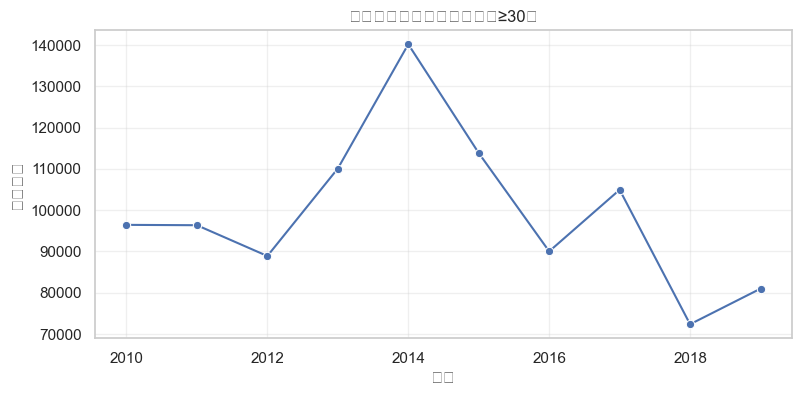

In [11]:
# 可视化 1：全国年度火点趋势
plt.figure(figsize=(9,4))
fires_year = fires_gdf.groupby('year').size().reset_index(name='count')
sns.lineplot(data=fires_year, x='year', y='count', marker='o')
plt.title('全国年度火点数量（置信度≥%d）' % CONF_THRESHOLD)
plt.xlabel('年份')
plt.ylabel('火点数量')
plt.grid(True, alpha=0.3)
plt.show()


## 核心任务 4：进行全国年度趋势、季节性与“高火点县”对比
已生成全国年度火点趋势线图 (2010-2019)，显示总体波动；月度季节性条形图，突出春季 (3-5月) 高发；Top10 高火点县横向条形图，按累计火点排序，识别热点区域。

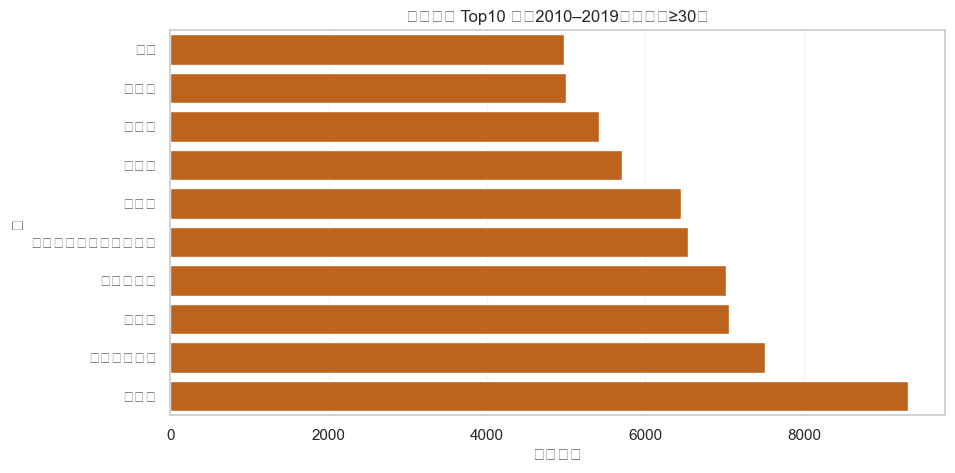

In [12]:
# 可视化 2：Top10 县（按累计火点）
plt.figure(figsize=(10,5))
rank = (agg_year.groupby(name_col)['fire_count'].sum()
         .sort_values(ascending=False).head(10)[::-1])
sns.barplot(x=rank.values, y=rank.index, orient='h', color='#d95f02')
plt.title('累计火点 Top10 县（2010–2019，置信度≥%d）' % CONF_THRESHOLD)
plt.xlabel('火点数量')
plt.ylabel('县')
plt.grid(axis='x', alpha=0.2)
plt.show()


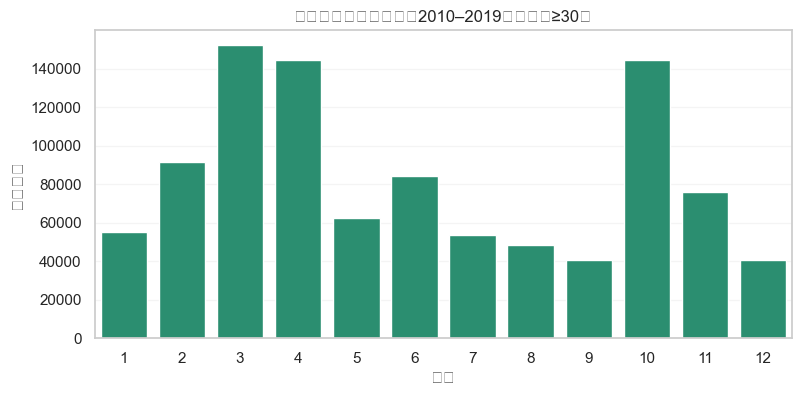

In [13]:
# 可视化 3：季节性（按月份汇总）
plt.figure(figsize=(9,4))
fires_month = fires_gdf.groupby('month').size().reset_index(name='count')
sns.barplot(data=fires_month, x='month', y='count', color='#1b9e77')
plt.title('全国月度火点季节性（2010–2019，置信度≥%d）' % CONF_THRESHOLD)
plt.xlabel('月份')
plt.ylabel('火点数量')
plt.grid(axis='y', alpha=0.2)
plt.show()


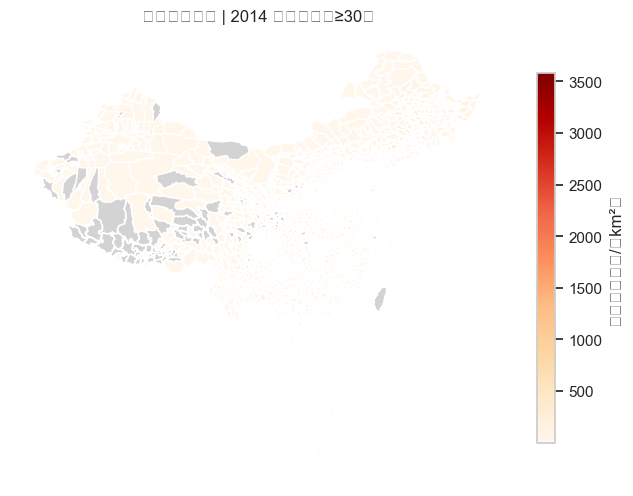

In [14]:
# 地图：选择某年展示县域火点密度（分级设色）
YEAR_TO_MAP = int(fires_gdf['year'].median())  # 默认选中位数年份

# 将密度指标与县界合并成GeoDataFrame
agg_y = agg_year_geo[agg_year_geo['year'] == YEAR_TO_MAP].copy()
# 保留县界几何
if name_col not in counties.columns:
    counties_plot = counties.rename(columns={counties.columns[0]: name_col})
else:
    counties_plot = counties[[name_col, 'geometry']].copy()

choropleth = counties_plot.merge(agg_y[[name_col, 'fire_density_per_1000km2']], on=name_col, how='left')

fig, ax = plt.subplots(1,1, figsize=(8,8))
choropleth.plot(column='fire_density_per_1000km2', ax=ax, cmap='OrRd', legend=True,
                legend_kwds={'label': '火点密度（次/千km²）', 'shrink': 0.6},
                missing_kwds={'color': 'lightgrey', 'label': '无记录'})
ax.set_title(f'县域火点密度 | {YEAR_TO_MAP} 年（置信度≥{CONF_THRESHOLD}）')
ax.axis('off')
plt.show()
